In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import gseapy
import seaborn as sns
# use anaconda/miniconda to ensure packages are right version, otherwise plotting might give error for color

## Load data

In [2]:
adata = sc.read_csv("data/GSM3399102_rawCounts.csv.gz").T

The raw UMI counts from Cell Ranger was processed by the Seurat R package (version 1.4) (Butler et al., 2018; Macosko et al., 2015). Genes that were detected in less than three cells were removed. Cells in which over 5% of the UMIs were mapped to the mitochondrial genes were discarded, and cells that contained less than 200 or over 4800 genes were considered outliers and discarded. Library-size normalization was performed on the UMI-collapsed gene expression for each barcode by scaling the total number of transcripts per cell to 10,000. The data were then log2 transformed. In total, 9,306 cells and 15,823 genes (an average of 1200 detected genes/cell) were used in the cell type determination.

Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. These variable genes were used in the principal component analysis. The first 23 principal components were used for cell clustering with a resolution at 0.6, and low dimensional reduction to visualize cell clusters. Specific genes for each cluster were identified using the Seurat’s FindAllMarkers function. To refine clustering, the SubsetData function was used to create a new Seurat object containing only a subset of the original cells and cell clustering was reiterated.



In [3]:
# filter genes expressed in less than 3 ells
sc.pp.filter_genes(adata, min_cells=3)

## 1. Quality control

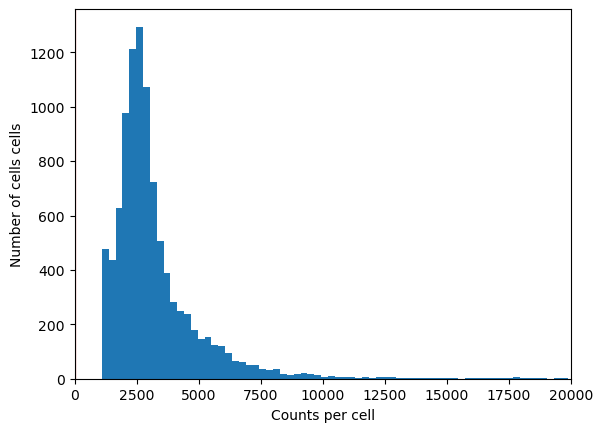

In [4]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Counts per cell") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of cells cells") # what are you plotting on the x-axis? Label it!
plt.axvline(0, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(0, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

From the plot, the data is already filtered for UMI counts per cell

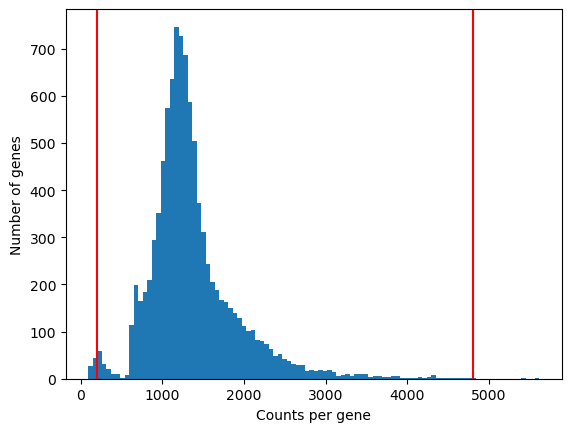

In [5]:
# look at gene counts per gene
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(200, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(4800, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel("Counts per gene") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of genes") # what are you plotting on the x-axis? Label it!
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

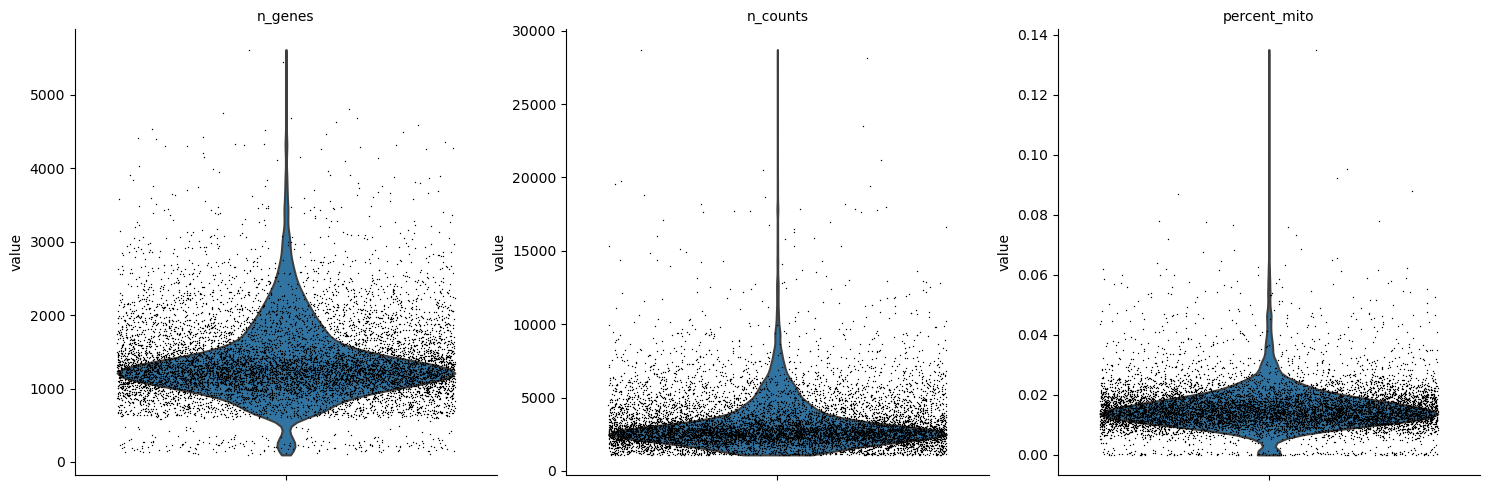

In [6]:
# finally check percentage of mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

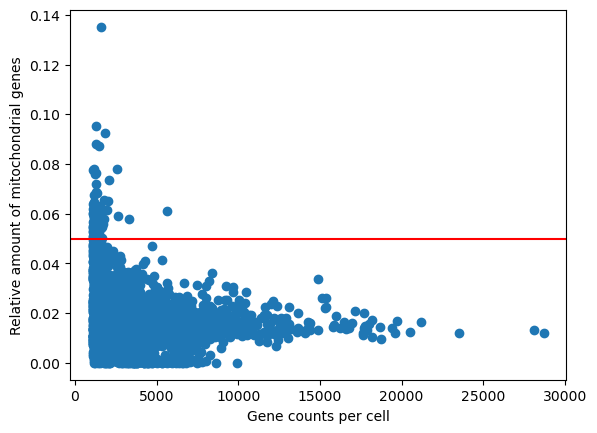

In [7]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel("Gene counts per cell") # specify the lower cutoff for number of detected genes
plt.ylabel("Relative amount of mitochondrial genes") # specify the lower cutoff for number of detected genes
plt.axhline(0.05, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

## 1.1 filter the data
Based on the above plots, we suggest to cut-off data for higher than 0.04 mitochondrial percentage,and to keep data within 500 and 3500 counts per gene and 1000to 10,000 gene counts per cell.
To improve, set boundaries with some algorithm based on the distributions?

In [8]:
sc.pp.filter_cells(adata, min_genes=200) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=4800) # apply threshold from above to actually do the filtering
adata = adata[adata.obs['percent_mito'] < 0.05, :].copy() # apply threshold from above to actually do the filtering

In [9]:
adata

AnnData object with n_obs × n_vars = 9708 × 15828
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

## 2. Normalization
Address variability caused by sc sequencing process

In [10]:
adata.raw = adata.copy()
adata_raw = adata.copy()

In [11]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

## 3. Feature selection

In [12]:
# Get cell states (S, G2m vs G1, G0)
S_genes_mouse = ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung',
       'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu',
       'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76',
       'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2',
       'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2',
       'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
G2M_genes_mouse = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a',
       'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf',
       'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb',
       'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp',
       'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1',
       'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr',
       'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2',
       'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

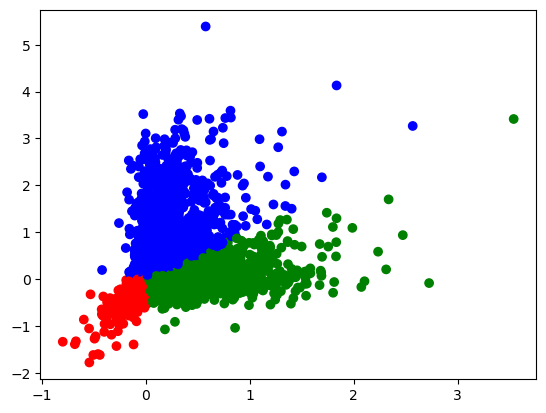

In [13]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
colors = []
for phase in adata.obs['phase']:
    colors.append(n2c[phase])

plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=colors)
plt.show()

In [14]:
adata.obs["phase"].value_counts()

phase
G1     6798
S      1849
G2M    1061
Name: count, dtype: int64

Also regress out the effect of cell phase. Authors did not do this, but seems like a good idea if we want to look at pseudo time. So cell phase does not confound those results, or at least less.

In [15]:
# Linear regression was used to regress out the total number of UMIs and the fraction of mitochondrial transcript content per cell. 
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score']) # specify which feature from adata.obs you want to regress out, if any

Select 1945 highest variance components, as the authors wrote:
The variable genes were identified using Seurat’s MeanVarPlot function using the following parameters: x.low.cutoff = 0.0; y.cutoff = 0.8, resulting in 1945 variable genes. 

In [16]:
sc.pp.highly_variable_genes(adata, n_top_genes=1945, min_disp=0.5, 
                            max_disp=np.inf, min_mean=0.0125, max_mean=3, span=0.3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [17]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

In [18]:
adata

AnnData object with n_obs × n_vars = 9708 × 1945
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## 4. Principal component analysis

In [19]:
sc.tl.pca(adata, svd_solver='arpack')

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


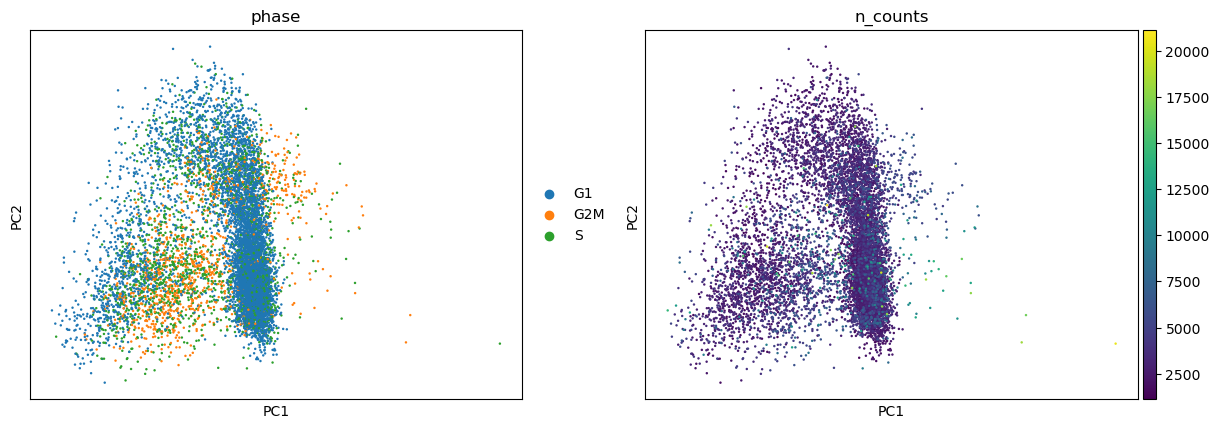

In [20]:
sc.pl.pca(adata, color=['phase','n_counts'])

In [21]:
# above shows a mix for the phase, which is good since it should be regressed out

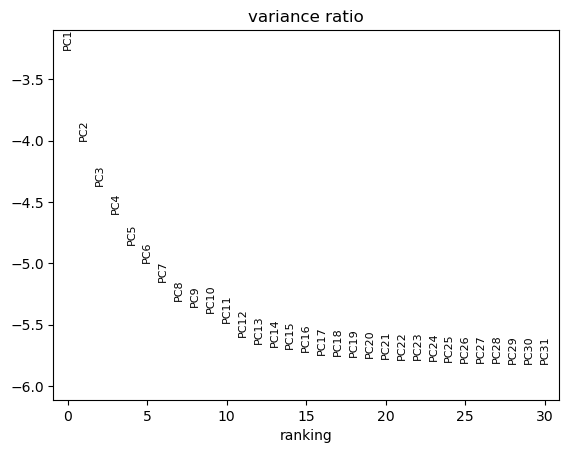

In [22]:
sc.pl.pca_variance_ratio(adata, log=True) # see contribution of each PC to variance

## 5. Dimensionality reduction 

In [23]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20) # specify the number of neighbors and number of PCs you wish to use

c:\Users\jurri\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
sc.tl.tsne(adata, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [25]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


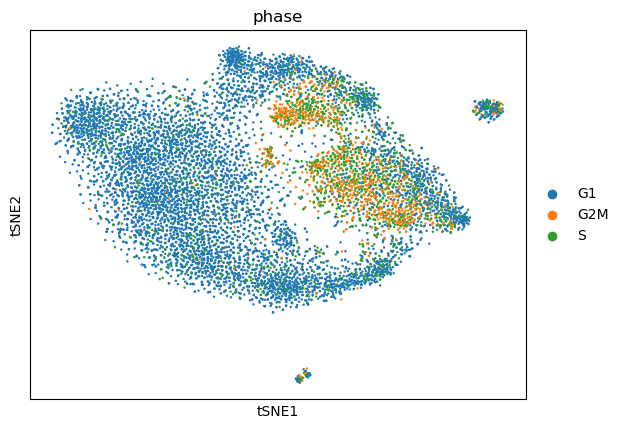

In [26]:
# visualize the tSNE colored by phase
sc.pl.tsne(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


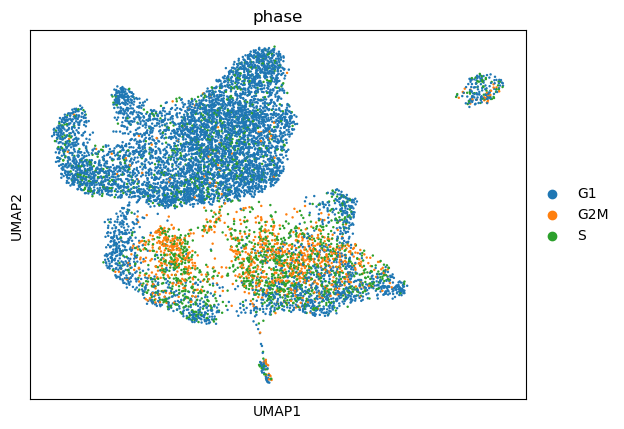

In [27]:
# visualize the UMAP colored by phase
sc.pl.umap(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

## 6. Clustering

In [28]:
resolution = 1.3
sc.tl.leiden(adata, resolution=resolution)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


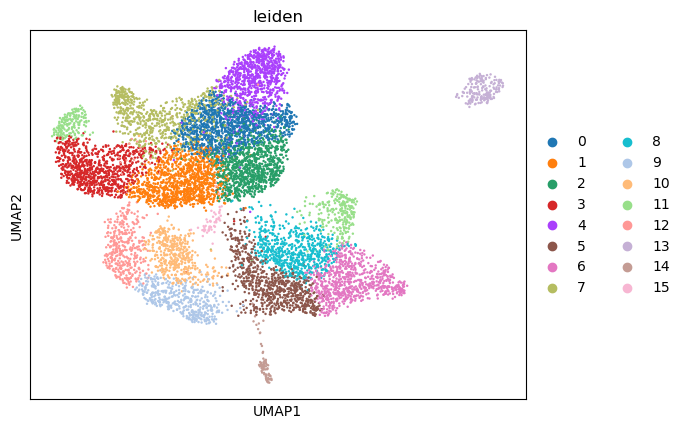

In [29]:
sc.pl.umap(adata, color=['leiden'], use_raw=False, wspace=0.3, ncols=2)

## 7. Identifying marker genes and cell types
Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [30]:
adata_raw_norm = adata_raw.copy()

# normalize the counts
sc.pp.normalize_total(adata_raw_norm)
# log transform the counts
sc.pp.log1p(adata_raw_norm)
# transfer over the metadata
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["leiden"] = [i for i in adata.obs["leiden"]]

In [31]:
sc.tl.rank_genes_groups(adata_raw_norm, 'leiden', use_raw=False, method="t-test")

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', use_raw=False, method='wilcoxon', key_added = "wilcoxon")


c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning:

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

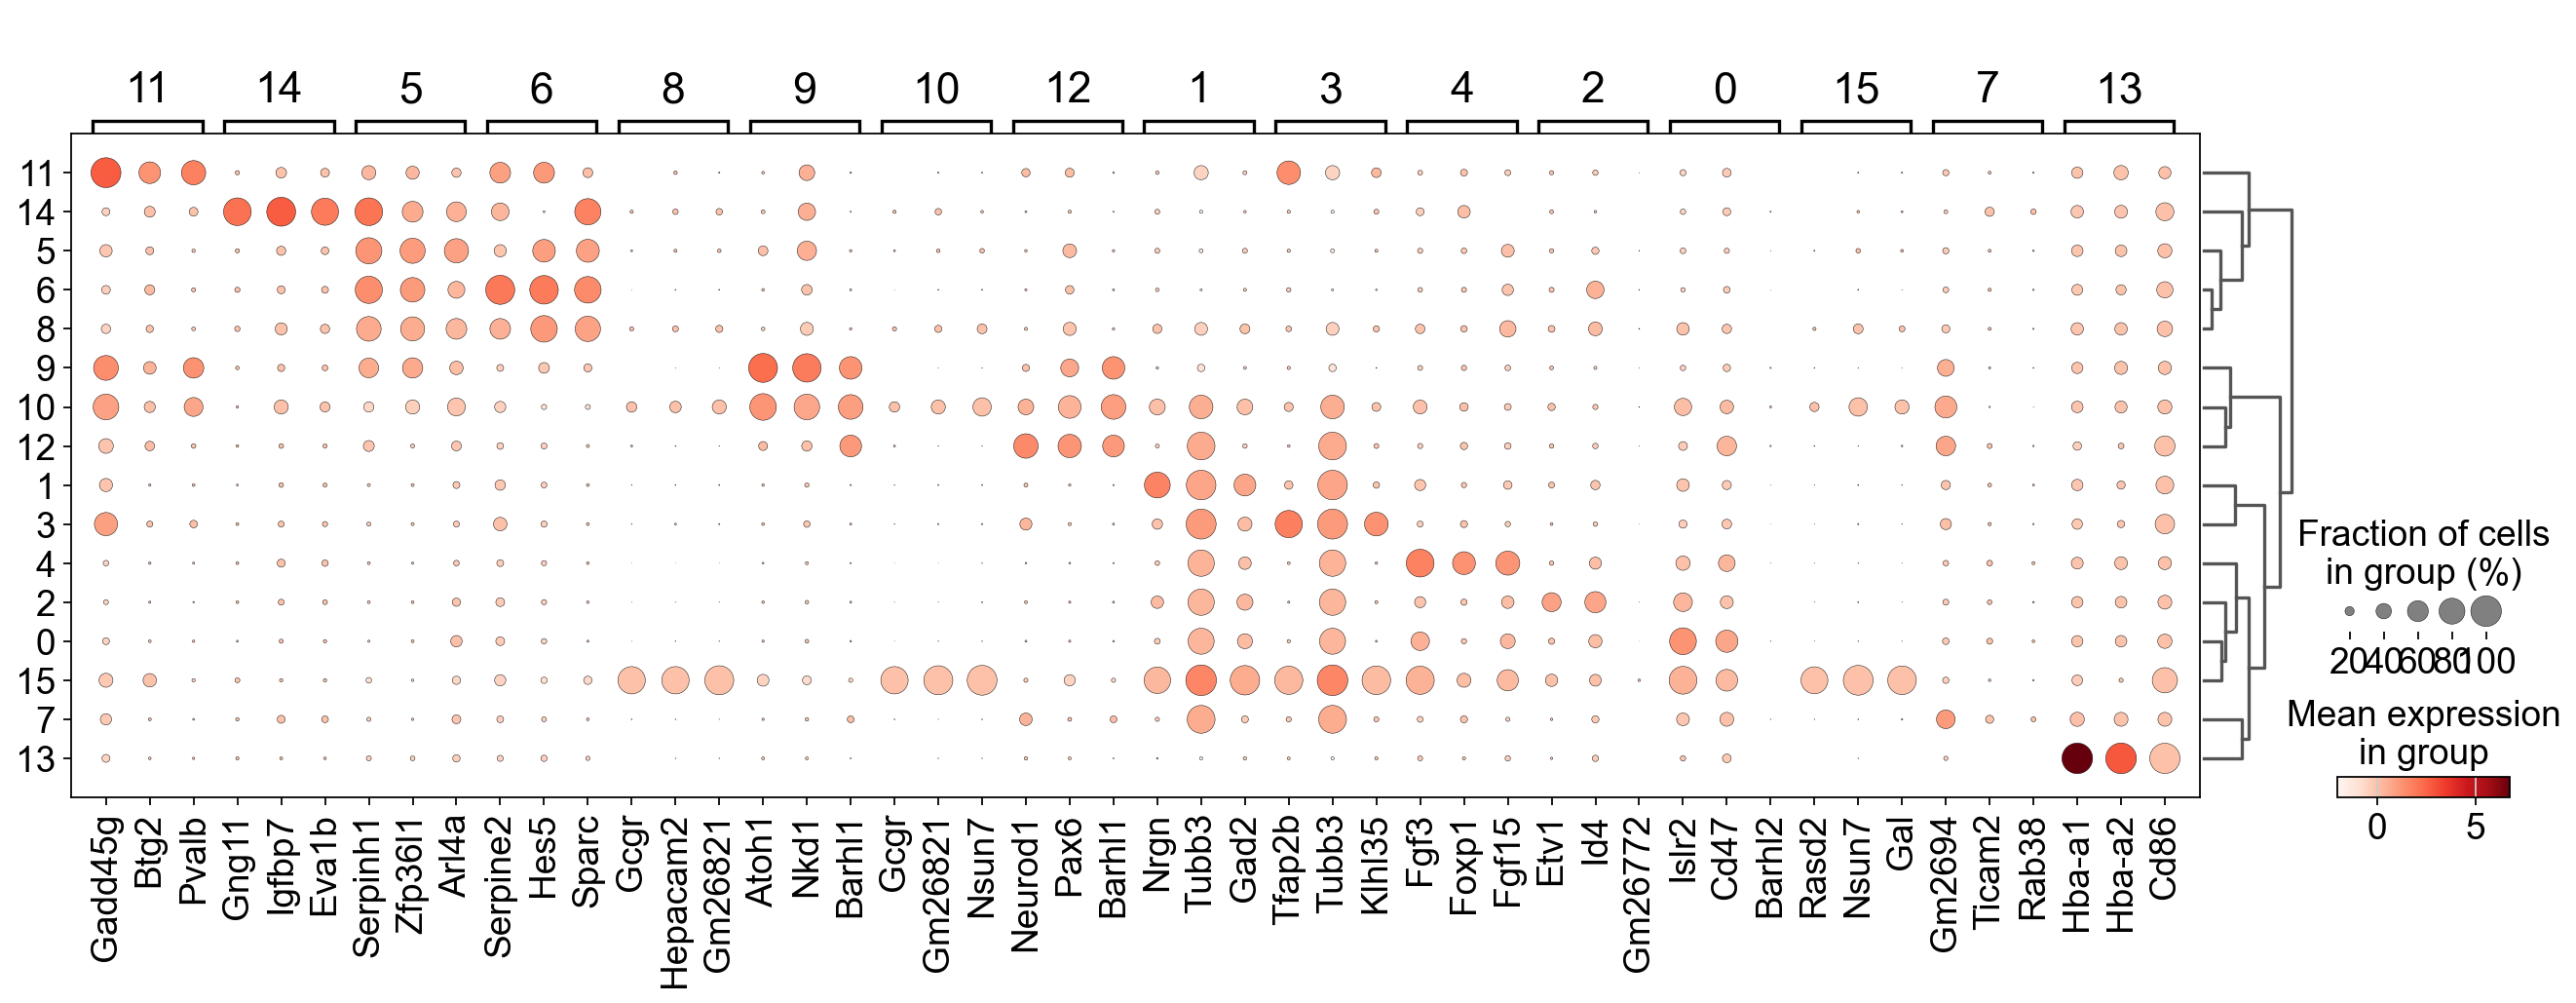

In [33]:
sc.set_figure_params(scanpy=True, fontsize=20) 
sc.pl.rank_genes_groups_dotplot(adata, use_raw=False, n_genes=3, key="wilcoxon", groupby="leiden")


In [34]:
marker_genes = pd.DataFrame(adata_raw_norm.uns["rank_genes_groups"]["names"])
marker_genes.iloc[:100].to_csv("most_variable.csv")

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_stacked_violin.py:324: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  _color_df = _matrix.groupby(level=0).median()
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\jurri\miniconda3\Li

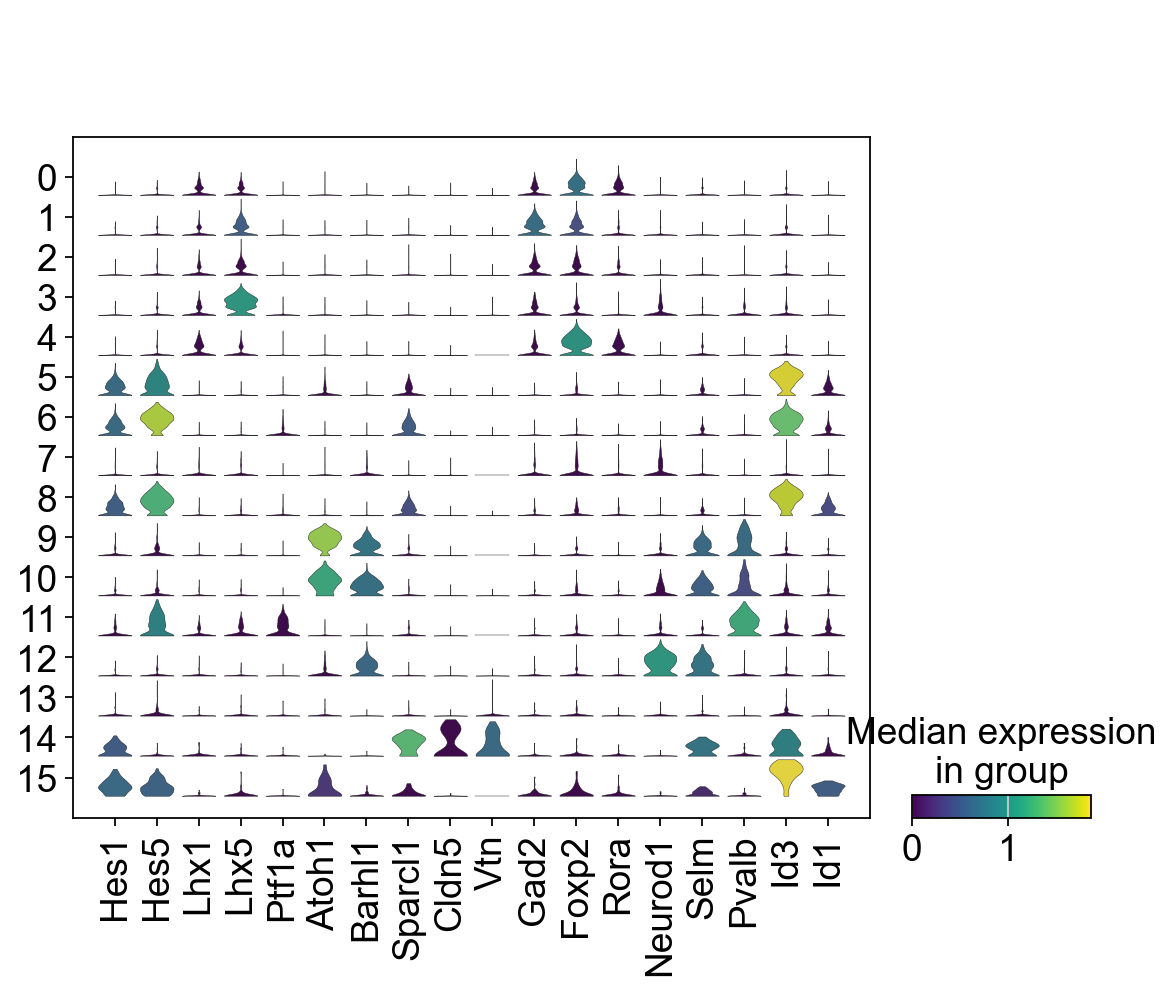

In [35]:
sc.pl.stacked_violin(
    adata_raw_norm, 
    [
        "Hes1", "Hes5", "Lhx1", "Lhx5", "Ptf1a", "Atoh1", 
        "Barhl1", "Sparcl1","Cldn5", "Vtn",
        "Gad2", "Foxp2", "Rora", "Neurod1", "Selm", "Pvalb", "Id3", "Id1"
    ], 
    groupby='leiden', 
    cmap='viridis',
    dendrogram=False,
    rotation=90,
    use_raw=False,
)

In [36]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6802724/ 
cluster2type_dict = {
    "0": "Gabaergic", 
    "1": "Gabaergic",
    "2": "Gabaergic",
    "3": "Gabaergic", 
    "4": "Purkinje",
    "5": "NPC",
    "6": "NPC",
    "7": "Granule neurons",
    "8": "NPC",
    "9": "glutamergic", 
    "10": "glutamergic",
    "11": "NPC gabaergic", 
    "12": "glutamergic",
    "13": "Other",
    "14": "NPC",
    "15": "NPC glutamergic",
}
cell_types = []
for key in cluster2type_dict:
    cell_types.append(cluster2type_dict[key])

In [37]:
adata.obs["cell_type"] = np.array([cluster2type_dict[i] for i in adata.obs["leiden"]])

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


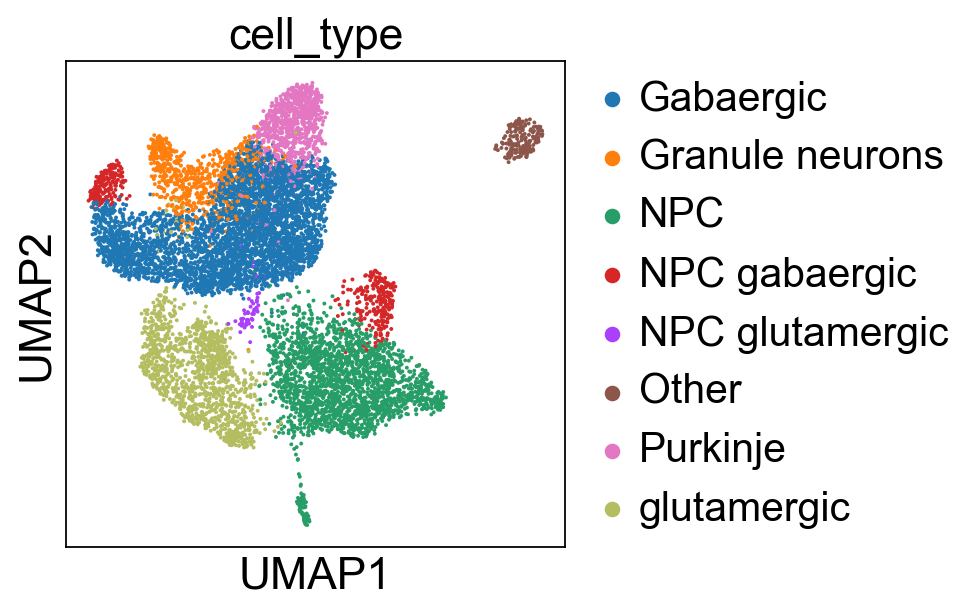

In [38]:
sc.pl.umap(adata, color=['cell_type'], use_raw=False, wspace=0.3, ncols=2)

## 8. Pseudo time analysis

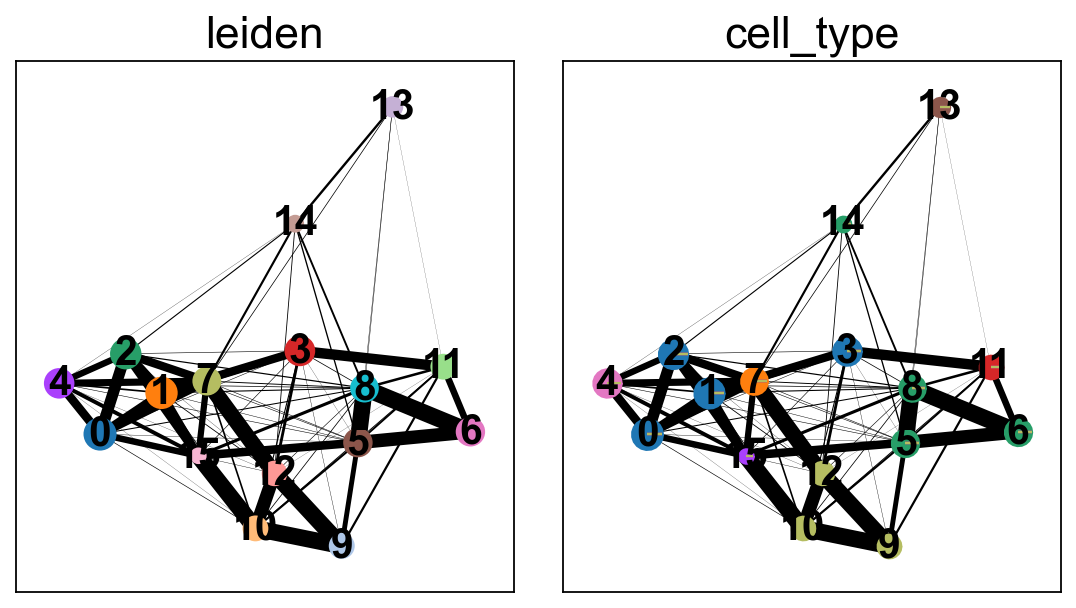

In [39]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', 'cell_type'])


## 8.1 Gabaergic pseudotime


In [40]:
gaba = adata[
    (adata.obs["cell_type"] == "Gabaergic")
    | (adata.obs["cell_type"] == "Purkinje")
    | (adata.obs["cell_type"] == "NPC gabaergic"), :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_49936\3698636052.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


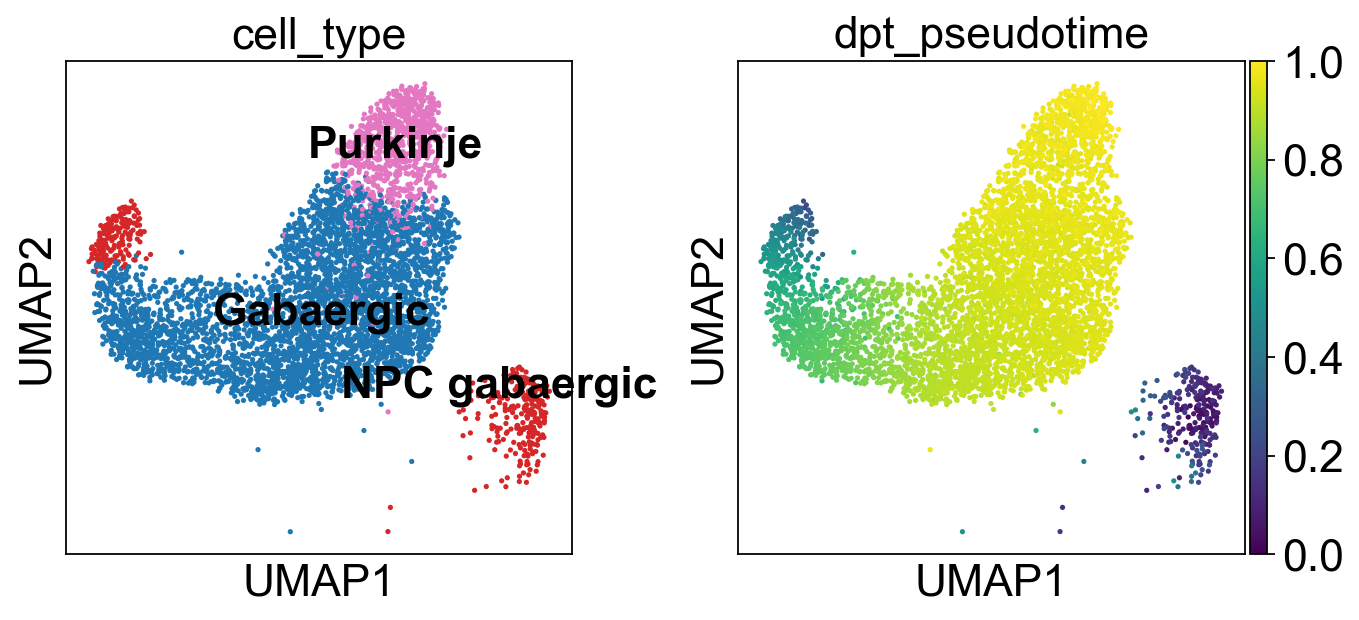

In [41]:
# Choose a root cel for diffusion
gaba.uns['iroot'] = np.flatnonzero(gaba.obs['cell_type']  == 'NPC gabaergic')[4]
sc.tl.diffmap(gaba)
sc.tl.dpt(gaba)
sc.pl.umap(gaba, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')

PLot the graph on which the above pseudotime is based

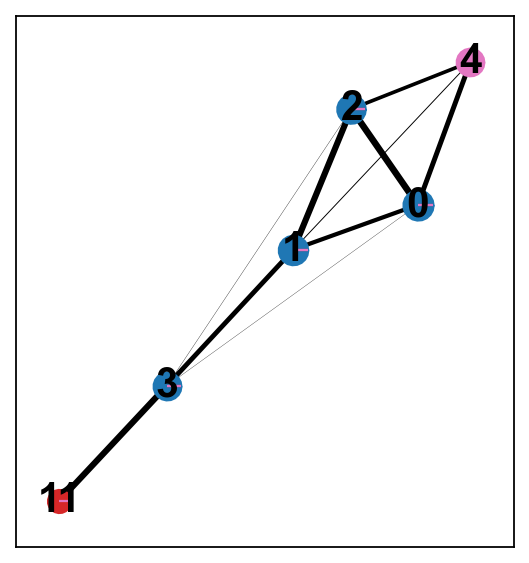

In [42]:
sc.tl.paga(gaba, groups='leiden')
sc.pl.paga(gaba, color=['cell_type'])

## 8.3 Follow markers genes
Here we will follow the expression of known marker genes through pseudotime

In [117]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9497131/
# https://www.antibodybeyond.com/reviews/cell-markers/purkinje-cell-marker.htm
# https://www.nature.com/articles/s41586-021-03220-z
marker_genes = {
    "Purkinje": [
        "Calb1",
        "Rora",
        "Foxp1",
#        "Foxp2", not there
        "Dab1",
        "Epha5",
        "Bcl11a",
        "Car8",
        "Tubb3",    # for maturation
    ],
    "Gabaergic":[
        "Gad1",
        "Gad2",
        "Lhx5",
    ],
    "Gabaergic NPC":[
        "Tfap2a",
        "Tfap2b", 
    ],
    "Interneuron dev":[
        "Ascl1", 
        "Neurog1",
        "Neurog2",
        "Pax2",
    ]
}
all_genes = [gene for genes in marker_genes.values() for gene in genes]

In [203]:
gene_indices = [np.array([int(i), str(x)]) for i, x in enumerate(gaba.var.index) if x in all_genes]
mapper = dict()
for i, index in enumerate(gene_indices):
    mapper[i] = index[1]
gene_indices = np.array(gene_indices)
gene_indices_ = np.array(gene_indices[:, 0],dtype=int)
expression_of_markers = gaba.X[:, gene_indices_]
pseudo_time = gaba.obs["dpt_pseudotime"]

df = pd.DataFrame(expression_of_markers)
df = df.rename(columns=mapper)
df["pseudotime"] = pseudo_time

In [207]:
import statsmodels.api as sm

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

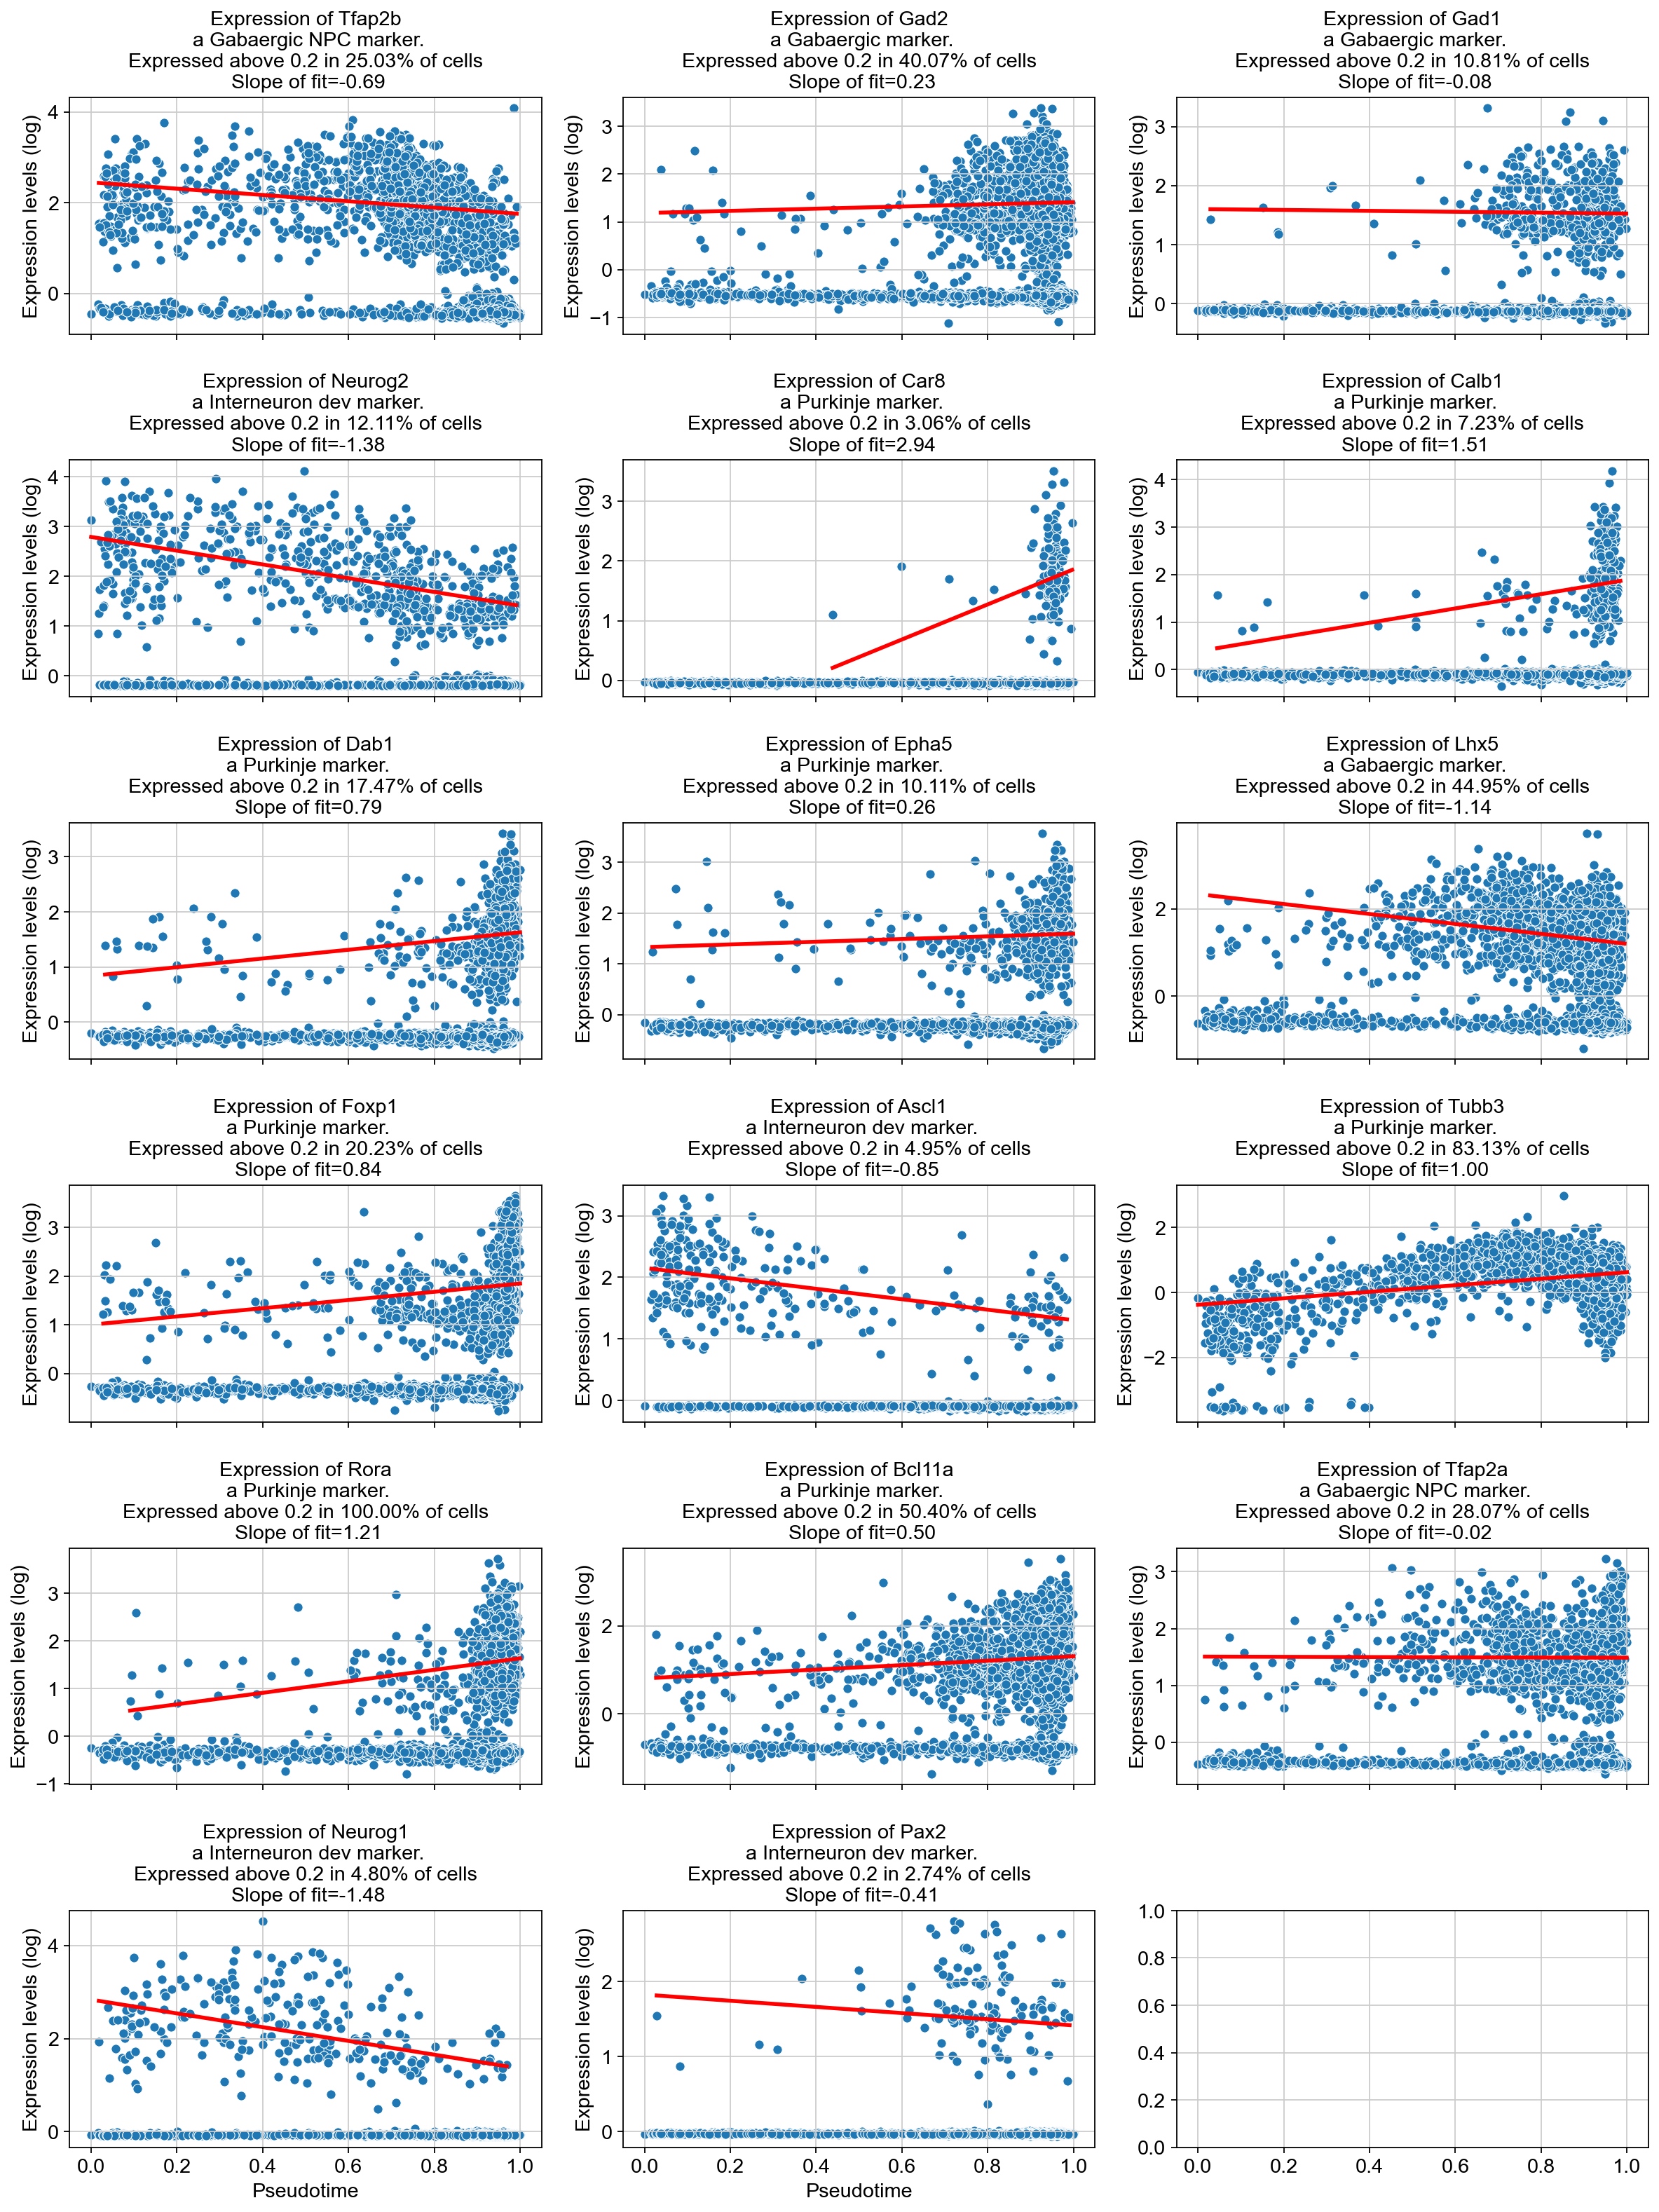

In [240]:
n_cols = 3
fig, axs = plt.subplots(6, n_cols, sharex=True, sharey=False, figsize=(15,20))
threshold  = 0.2
for i in range(len(gene_indices)):
    x_plot = i % n_cols
    y_plot = int(np.floor(i/n_cols))
    # find marker type
    for group in marker_genes:
        if gene_indices[i, 1] in marker_genes[group]:
            break
    # count for how many cells expression is greater than 0.2
    expressed = np.sum(expression_of_markers[:, i] > threshold)/len(expression_of_markers[:, i])*100
    if gene_indices[i, 1] == "Tubb3":
        threshold = -10
    else:
        threshold = 0
    # above zero
    above_zero = expression_of_markers[:, i] > threshold
    
    # make model
    X = pseudo_time[above_zero]
    X = sm.add_constant(X)
    y = expression_of_markers[above_zero, i]
    mod = sm.OLS(y, X) 
    res = mod.fit()
    coeff = res.params.dpt_pseudotime
    intercept = res.params.const
    # do plotting
    sns.scatterplot(x=pseudo_time[:], y=expression_of_markers[:, i], ax=axs[y_plot, x_plot], markers='x')
    sns.lineplot(x=pseudo_time[above_zero], y=pseudo_time[above_zero]*coeff+intercept, ax=axs[y_plot, x_plot], color='red', linewidth=2.5)
    # set titles
    axs[y_plot, x_plot].set_title(f"Expression of {gene_indices[i, 1]}\n a {group} marker.\nExpressed above 0.2 in {expressed:.2f}% of cells\n Slope of fit={coeff:.2f}")
    axs[y_plot, x_plot].set_ylabel("Expression levels (log)")
    axs[y_plot, x_plot].set_xlabel("Pseudotime")

fig.tight_layout()
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The def

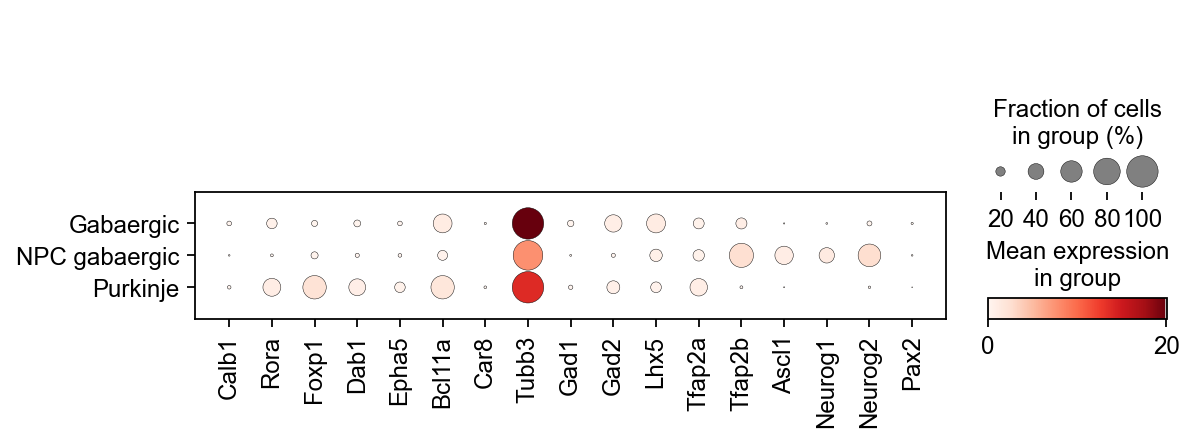

In [241]:
sc.tl.rank_genes_groups(gaba , 'cell_type', use_raw=False, method='wilcoxon', key_added = "wilcoxon")
sc.pl.dotplot(gaba,all_genes, groupby='cell_type')


## 8.3 Based on the above, narrow down the groups further

In [254]:
gene_indices

array([['2', 'Tfap2b'],
       ['143', 'Gad2'],
       ['189', 'Gad1'],
       ['433', 'Neurog2'],
       ['459', 'Car8'],
       ['464', 'Calb1'],
       ['503', 'Dab1'],
       ['620', 'Epha5'],
       ['658', 'Lhx5'],
       ['765', 'Foxp1'],
       ['1017', 'Ascl1'],
       ['1142', 'Tubb3'],
       ['1258', 'Rora'],
       ['1332', 'Bcl11a'],
       ['1484', 'Tfap2a'],
       ['1500', 'Neurog1'],
       ['1934', 'Pax2']], dtype='<U11')

In [265]:
npc_purkinje = gaba[
    ((gaba.obs["cell_type"] == "Purkinje") & (gaba.X[:, 1258] > 0.2))   # Rora
    | ((gaba.obs["cell_type"] == "NPC gabaergic") & ((gaba.X[:, 1500] > 0.2) | (gaba.X[:, 433] > 0.2) )), :]   # Neurog1 or neurog2

In [266]:
npc_purkinje.obs['cell_type'].value_counts()
# similar group size

cell_type
Purkinje         402
NPC gabaergic    312
Name: count, dtype: int64

## 8.4 Compare NPC to purkinje

In [267]:
purkinje_vs_npc = npc_purkinje

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


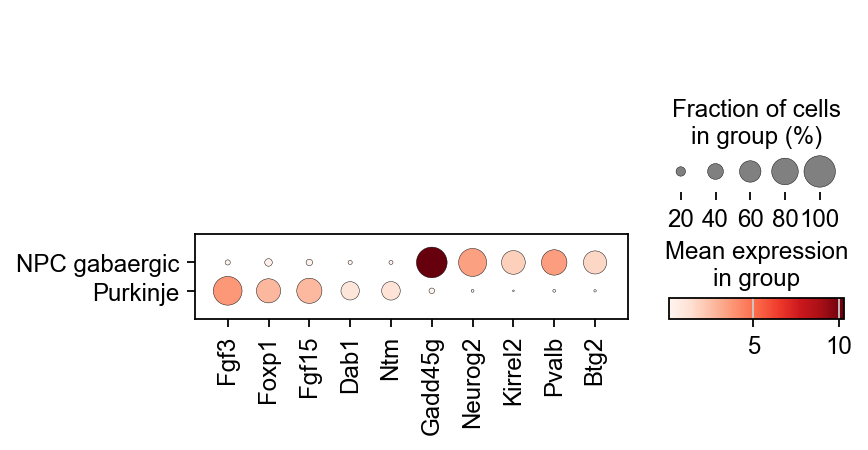

In [268]:
gaba_genes = []
for cat in purkinje_vs_npc.obs["cell_type"].unique():
    gaba_genes += sc.get.rank_genes_groups_df(purkinje_vs_npc, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.set_figure_params(scanpy=True, fontsize=13) 
sc.pl.dotplot(purkinje_vs_npc,gaba_genes, groupby='cell_type')


In [269]:
# get gene lists of interest
comparments = {}
processes = {}
for cat in purkinje_vs_npc.obs["cell_type"].unique():
    glist = sc.get.rank_genes_groups_df(purkinje_vs_npc, group=cat, 
                                    key='wilcoxon', log2fc_min=0.5, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
    print(f"For category {cat} consider {len(glist)} genes")
    if glist:
        comparments[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Cellular_Component_2023',
                        background=purkinje_vs_npc.var.index.to_list(),
                        cutoff = 0.5)
        processes[cat] = gseapy.enrichr(gene_list=glist,
                        organism='Mouse',
                        gene_sets='GO_Biological_Process_2023',
                         background=purkinje_vs_npc.var.index.to_list(),
                        cutoff = 0.5)
    

For category Purkinje consider 500 genes
For category NPC gabaergic consider 348 genes


In [272]:
comparments["Purkinje"].results.head(10)

Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   P-value  \
0        Response To Type II Interferon (GO:0034341)  0.004068   
1  Positive Regulation Of Carbohydrate Metabolic ...  0.004328   
2                         Odontogenesis (GO:0042476)  0.004835   
3  Regulation Of Epidermal Growth Factor Receptor...  0.005225   
4  Negative Regulation Of Myeloid Leukocyte Diffe...  0.005225   
5                  Regulated Exocytosis (GO:0045055)  0.005225   
6                           Translation (GO:0006412)  0.011372   
7  Cellular Response To Type II Interferon (GO:00...  0.014428   
8             Mitochondrial Translation (GO:0032543)  0.014428   
9  Negative Regulation Of Cell Cycle G1/S Phase T...  0.014428   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.831336            0                     0    6.824882   
1          0.831336            0                     0         inf   
2          0.831336            0                     0    8.763158   
3          0.831336            0                     0   14.585859   
4          0.831336            0                     0   14.585859   
5          0.831336            0                     0   14.585859   
6          0.831336            0                     0    5.838057   
7          0.831336            0                     0    7.287879   
8          0.831336            0                     0    7.287879   
9          0.831336            0                     0    7.287879   

   Combined Score                                   Genes  
0       37.567771      KYNU;CCL4;CCL3;CCL2;CD47;AIF1;SNCA  
1             inf                  PMAIP1;ARNT;GPLD1;SNCA  
2       46.724387     COL1A1;WNT6;COL1A2;MSX1;AXIN2;OXSR1  
3       76.638057          ZFYVE28;GPER1;NUP62;EGFR;PTPN2  
4       76.638057            CCL3;CARTPT;PTPN2;FSTL3;C1QC  
5       76.638057  SNAP25;SYNGR3;RAB11FIP2;RAB11FIP5;SNCA  
6       26.134561     MRPL3;TSFM;FTSJ1;RPL6;MRPL21;MRPL44  
7       30.890337                CCL4;CCL3;CCL2;CD47;AIF1  
8       30.890337         MRPL3;TSFM;MTRF1L;MRPL21;MRPL44  
9       30.890337         CDKN1A;DCUN1D3;SUSD2;CCL2;CDC73

In [271]:
comparments["NPC gabaergic"].results.head(10)

Gene_set  \
0  GO_Cellular_Component_2023   
1  GO_Cellular_Component_2023   
2  GO_Cellular_Component_2023   
3  GO_Cellular_Component_2023   
4  GO_Cellular_Component_2023   
5  GO_Cellular_Component_2023   
6  GO_Cellular_Component_2023   
7  GO_Cellular_Component_2023   
8  GO_Cellular_Component_2023   
9  GO_Cellular_Component_2023   

                                                Term   P-value  \
0                         Lipid Droplet (GO:0005811)  0.011983   
1              Organelle Outer Membrane (GO:0031968)  0.020502   
2          Mitochondrial Outer Membrane (GO:0005741)  0.038619   
3          SCF Ubiquitin Ligase Complex (GO:0019005)  0.042791   
4                Mitochondrial Membrane (GO:0031966)  0.059667   
5                               Spindle (GO:0005819)  0.085880   
6   Cytoplasmic Side Of Plasma Membrane (GO:0009898)  0.088054   
7                    Lysosomal Membrane (GO:0005765)  0.100539   
8  cullin-RING Ubiquitin Ligase Complex (GO:0031461)  0.117086   
9            Azurophil Granule Membrane (GO:0035577)  0.149155   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.926202            0                     0    5.805394   
1          0.926202            0                     0    4.641399   
2          0.926202            0                     0    4.630814   
3          0.926202            0                     0    6.934783   
4          0.926202            0                     0    2.093363   
5          0.926202            0                     0    2.317251   
6          0.926202            0                     0    2.572076   
7          0.926202            0                     0    2.028409   
8          0.926202            0                     0    2.641196   
9          0.926202            0                     0    4.609827   

   Combined Score                                              Genes  
0       25.684734                  CLDN11;DGAT2;VPS13C;ALOX15;VPS13A  
1       18.042205                     CLMN;FUNDC1;VPS13C;RAC2;VPS13A  
2       15.068699                          FUNDC1;VPS13C;RAC2;VPS13A  
3       21.854506                                 USP47;FBXL8;FBXO32  
4        5.901127  SLC25A27;FUNDC1;VPS13C;RAC2;VPS13A;SLC25A32;SD...  
5        5.688400                SPAG5;DCTN1;PRC1;CDC16;CD180;CHAMP1  
6        6.249644                    TIAM1;RASA3;ALOX15;PTEN;PLEKHA4  
7        4.659681       SLC46A3;VPS13A;C3AR1;PRCP;TM6SF1;AP5B1;GPLD1  
8        5.664956                           FBXL8;USP47;CDC16;FBXO32  
9        8.771446                                         C3AR1;PRCP

In [273]:
processes["Purkinje"].results.head(10)

Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   P-value  \
0        Response To Type II Interferon (GO:0034341)  0.004068   
1  Positive Regulation Of Carbohydrate Metabolic ...  0.004328   
2                         Odontogenesis (GO:0042476)  0.004835   
3  Regulation Of Epidermal Growth Factor Receptor...  0.005225   
4  Negative Regulation Of Myeloid Leukocyte Diffe...  0.005225   
5                  Regulated Exocytosis (GO:0045055)  0.005225   
6                           Translation (GO:0006412)  0.011372   
7  Cellular Response To Type II Interferon (GO:00...  0.014428   
8             Mitochondrial Translation (GO:0032543)  0.014428   
9  Negative Regulation Of Cell Cycle G1/S Phase T...  0.014428   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.831336            0                     0    6.824882   
1          0.831336            0                     0         inf   
2          0.831336            0                     0    8.763158   
3          0.831336            0                     0   14.585859   
4          0.831336            0                     0   14.585859   
5          0.831336            0                     0   14.585859   
6          0.831336            0                     0    5.838057   
7          0.831336            0                     0    7.287879   
8          0.831336            0                     0    7.287879   
9          0.831336            0                     0    7.287879   

   Combined Score                                   Genes  
0       37.567771      KYNU;CCL4;CCL3;CCL2;CD47;AIF1;SNCA  
1             inf                  PMAIP1;ARNT;GPLD1;SNCA  
2       46.724387     COL1A1;WNT6;COL1A2;MSX1;AXIN2;OXSR1  
3       76.638057          ZFYVE28;GPER1;NUP62;EGFR;PTPN2  
4       76.638057            CCL3;CARTPT;PTPN2;FSTL3;C1QC  
5       76.638057  SNAP25;SYNGR3;RAB11FIP2;RAB11FIP5;SNCA  
6       26.134561     MRPL3;TSFM;FTSJ1;RPL6;MRPL21;MRPL44  
7       30.890337                CCL4;CCL3;CCL2;CD47;AIF1  
8       30.890337         MRPL3;TSFM;MTRF1L;MRPL21;MRPL44  
9       30.890337         CDKN1A;DCUN1D3;SUSD2;CCL2;CDC73

In [274]:
processes["NPC gabaergic"].results.head(10)

Gene_set  \
0  GO_Biological_Process_2023   
1  GO_Biological_Process_2023   
2  GO_Biological_Process_2023   
3  GO_Biological_Process_2023   
4  GO_Biological_Process_2023   
5  GO_Biological_Process_2023   
6  GO_Biological_Process_2023   
7  GO_Biological_Process_2023   
8  GO_Biological_Process_2023   
9  GO_Biological_Process_2023   

                                                Term   P-value  \
0  Regulation Of Actin Filament Polymerization (G...  0.000639   
1  Regulation Of Actin Polymerization Or Depolyme...  0.001010   
2  Regulation Of Protein Polymerization (GO:0032271)  0.004335   
3  Regulation Of Osteoclast Differentiation (GO:0...  0.005687   
4  Negative Regulation Of Osteoclast Differentiat...  0.005687   
5  Negative Regulation Of Cellular Catabolic Proc...  0.006231   
6  Regulation Of Intracellular Signal Transductio...  0.013949   
7          Dendritic Spine Organization (GO:0097061)  0.019718   
8            Dopamine Metabolic Process (GO:0042417)  0.019718   
9                    Vacuolar Transport (GO:0007034)  0.019718   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.688018            0                     0   13.991228   
1          0.688018            0                     0         inf   
2          0.688018            0                     0   18.558140   
3          0.688018            0                     0         inf   
4          0.688018            0                     0         inf   
5          0.688018            0                     0    7.745384   
6          0.688018            0                     0    2.749739   
7          0.688018            0                     0   13.878261   
8          0.688018            0                     0   13.878261   
9          0.688018            0                     0   13.878261   

   Combined Score                                              Genes  
0      102.913377                  ALOX15;HCLS1;ESAM;PAK3;PFN3;KANK3  
1             inf                               HCLS1;ESAM;PAK3;PFN3  
2      100.973854                               HCLS1;ESAM;PAK3;PFN3  
3             inf                                  CCL3;CARTPT;FSTL3  
4             inf                                  CCL3;CARTPT;FSTL3  
5       39.333048                      DAPL1;RRAGD;APOC1;TREM2;GPLD1  
6       11.747848  RASD2;TIAM1;CSF1R;PTEN;ATM;TREM2;PAK3;KALRN;OP...  
7       54.489501                                    PTEN;TREM2;PAK3  
8       54.489501                                      DBH;DRD4;SNCA  
9       54.489501                               VPS13C;VPS13A;VPS37A

# END

## NPC pseudo time

In [54]:
NPC = adata[
    (adata.obs["cell_type"] == "NPC")
    | (adata.obs["cell_type"] == "NPC glutamergic")
    | (adata.obs["cell_type"] == "NPC gabaergic"),
    :]

C:\Users\jurri\AppData\Local\Temp\ipykernel_49936\1609575589.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


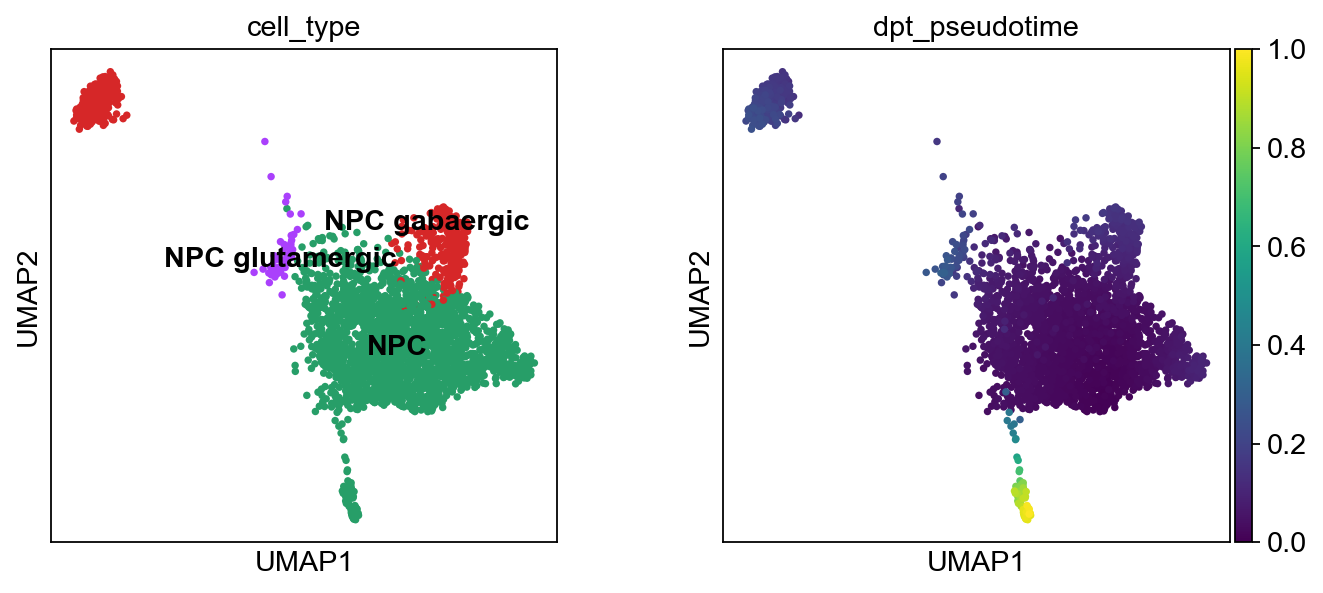

In [55]:
# Choose a root cel for diffusion
NPC.uns['iroot'] = np.flatnonzero(NPC.obs['cell_type']  == 'NPC')[4]
sc.tl.diffmap(NPC)
sc.tl.dpt(NPC)
sc.pl.umap(NPC, color=['cell_type', 'dpt_pseudotime'], legend_loc='on data')


In [56]:
NPC.obs['cell_type'].value_counts()

cell_type
NPC                2182
NPC gabaergic       413
NPC glutamergic      57
Name: count, dtype: int64

In [57]:
target_cells = 57
tmp = [NPC[NPC.obs['cell_type'] == s] for s in NPC.obs['cell_type'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

npc_sampled = tmp[0].concatenate(*tmp[1:])
npc_sampled.obs['cell_type'].value_counts()

C:\Users\jurri\AppData\Local\Temp\ipykernel_49936\2450881020.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  npc_sampled = tmp[0].concatenate(*tmp[1:])


cell_type
NPC                57
NPC gabaergic      57
NPC glutamergic    57
Name: count, dtype: int64

In [58]:
sc.tl.rank_genes_groups(npc_sampled , 'cell_type', use_raw=False, method='wilcoxon', key_added = "wilcoxon")

c:\Users\jurri\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


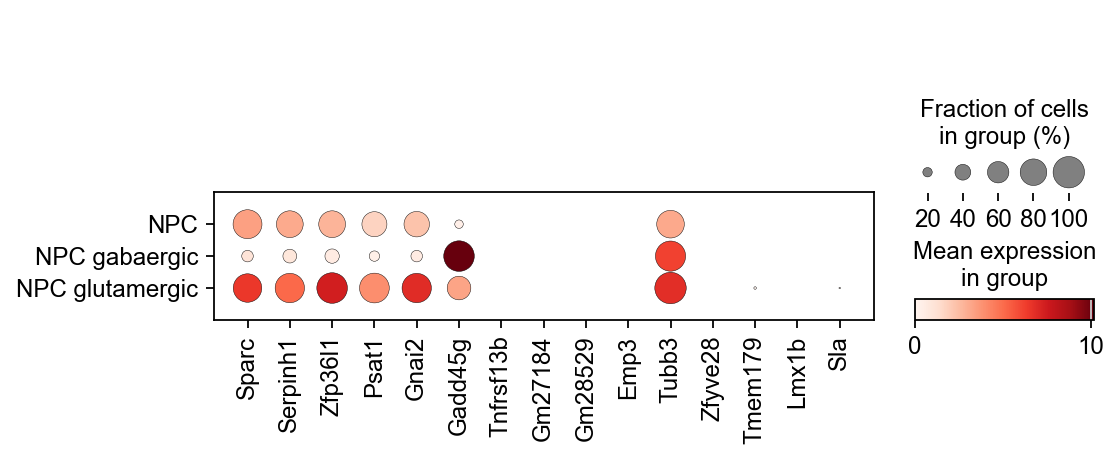

In [59]:
npc_genes = []
for cat in npc_sampled.obs["cell_type"].unique():
    npc_genes += sc.get.rank_genes_groups_df(npc_sampled, group=cat, key='wilcoxon')['names'][:5].tolist()

sc.pl.dotplot(npc_sampled,npc_genes, groupby='cell_type')